In [ ]:
import nltk
nltk.download('stopwords')

In [160]:
import nltk
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout
from keras.layers import InputLayer
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

#!spell login #henmja, a****

In [161]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_pickle("bigdataHashed.pkl")
df.tail()

,contributors_enabled_user,created_at,created_at_user,default_profile_image_user,default_profile_user,description_user,display_url_zero_urls_entities,display_url_zero_urls_url_entities_user,expanded_url_zero_urls_entities,expanded_url_zero_urls_url_entities_user,favorite_count,favorited,favourites_count_user,follow_request_sent_user,followers_count_user,following_user,friends_count_user,geo_enabled_user,has_extended_profile_user,id,id_str,id_str_user,id_str_zero_user_mentions_entities,id_user,id_zero_user_mentions_entities,is_quote_status,is_translation_enabled_user,is_translator_user,lang,listed_count_user,location_user,name_user,name_zero_user_mentions_entities,notifications_user,possibly_sensitive,possibly_sensitive_appealable,profile_background_color_user,profile_background_image_url_https_user,profile_background_image_url_user,profile_background_tile_user,profile_banner_url_user,profile_image_url_https_user,profile_image_url_user,profile_link_color_user,profile_sidebar_border_color_user,profile_sidebar_fill_color_user,profile_text_color_user,profile_use_background_image_user,protected_user,retweet_count,retweeted,screen_name_user,screen_name_zero_user_mentions_entities,source,statuses_count_user,text,translator_type_user,truncated,url_user,url_zero_urls_entities,url_zero_urls_url_entities_user,verified_user,zero_indices_zero_urls_entities,one_indices_zero_urls_entities,zero_indices_zero_urls_url_entities_user,one_indices_zero_urls_url_entities_user,zero_indices_zero_user_mentions_entities,one_indices_zero_user_mentions_entities,followers,following,label
788,False,2017-05-20 14:11:39+00:00,Sun Oct 25 14:01:48 +0000 2009,False,True,,fb.me/1fYsjNaLC,thekind-heartedsmartaleck.blogspot.com,http://fb.me/1fYsjNaLC,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,16.0,False,47.0,False,87.0,True,True,8.659330e+17,8.659330e+17,85085807,10228272,8.508581e+07,8.529181e+16,False,False,False,en,7.0,Gassaway WV,Terry Bly,YouTube,False,False,False,C0DEED,https://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/13552184...,https://pbs.twimg.com/profile_images/249393875...,http://pbs.twimg.com/profile_images/2493938757...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,TlbBly,YouTube,"<a href=""http://www.facebook.com/twitter"" rel=...",90486.0,WORSE THAN HITLER! Trey Gowdy’s Son Found In A...,none,False,None,https://t.co/dxpndRqHjL,http://t.co/PYrnTHpCvI,False,93.0,116.0,0.0,22.545205,49.264865,60.043243,8165876438847090636,8165876438847090636,fake
789,False,2017-12-09 09:10:03+00:00,Wed Feb 24 22:58:57 +0000 2016,False,True,PROUD PATRIOT SUPPORTING TRUMP!! PRO-AMERICAN....,twitter.com/i/web/status/9…,thekind-heartedsmartaleck.blogspot.com,https://twitter.com/i/web/status/9394218766187...,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,74641.0,False,6903.0,False,4533.0,True,True,9.394219e+17,9.394219e+17,702628810483765249,10228272,7.026288e+17,8.529181e+16,False,False,False,en,86.0,"Orlando, FL",#TRUMP2020,YouTube,False,False,False,F5F8FA,None,None,False,https://pbs.twimg.com/profile_banners/70262881...,https://pbs.twimg.com/profile_images/111902430...,http://pbs.twimg.com/profile_images/1119024306...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,PolyPatriot,YouTube,"<a href=""http://twitter.com/download/iphone"" r...",155849.0,Facebook Picks Sides in Alabama Senate Race=&g...,none,True,None,https://t.co/o4Qq2UFraj,http://t.co/PYrnTHpCvI,False,120.0,143.0,0.0,22.545205,49.264865,60.043243,3430018387555,3430018387555,fake
790,False,2017-08-29 17:54:38+00:00,Tue Sep 15 02:55:59 +0000 2009,False,True,,houstonchronicle-tv.com/floyd-mayweath…,thekind-heartedsmartaleck.blogspot.com,http://houstonchronicle-tv.com/floyd-mayweathe...,http://thekind-heartedsmartaleck.blogspot.com/,1.0,False,11.0,False,24.0,False,42.0,True,False,9.025903e+17,9.025903e+17,74346965,10228272,7.434696e+07,8.529181e+16,False,False,False,en,0.0,Louisville Ky,Eugene 

In [327]:

    
df['created_at'] = df['created_at'].astype(str)
df['followers'] = df['followers'].astype(str)
df['following'] = df['following'].astype(str)
#https://datascience.stackexchange.com/questions/67145/word-embedding-or-hash

#convert followers og following til words og bruk bigdataClean
#normalize numeric values
#http://digital-thinking.de/deep-learning-combining-numerical-and-text-features-in-deep-neural-networks/
#concatenate numeric values og kjør LSTM med to inputs
#increase Sequence length med antall attributes og embed numeric attributes og bruk sequential hvis to inputs ikke går.
#word embedding av bigdataClean og LSTM. Order followers før embedding? (gloves er trent til å behandle ord som tall)
#prøve uten normalize?

In [328]:
#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'source', 'display_url_zero_urls_entities', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'display_url_zero_urls_url_entities_user', 'expanded_url_zero_urls_entities', 'expanded_url_zero_urls_url_entities_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_image_url_https_user', 'profile_background_image_url_user', 'profile_background_tile_user', 'profile_banner_url_user', 'profile_image_url_https_user', 'profile_image_url_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'url_user', 'url_zero_urls_entities', 'url_zero_urls_url_entities_user', 'verified_user']
xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_tile_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user', 'followers', 'following']
#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_tile_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user', 'followers', 'following']
x = 'created_at: ' + df['created_at'] + ' - text: ' + df['text']
i = 0
for col in xCols:
    df[col] = df[col].astype(str)
for idx in xCols:
    if i>1:
        x = x + ' - ' + str(idx) + ': ' + df[idx]
    i=i+1
#x = df[xCols].apply(lambda row: .join(row.values.astype(str)), axis=1)
print(x[0])

created_at: 2015-10-09 21:18:53+00:00 - text: Missed @marcorubio in NH this week? Come to a town hall meeting in Derry on Wednesday. #fitn #nhpolitics #nhformarco https://t.co/FlrKPldQ76 - created_at_user: Fri Jun 27 23:15:54 +0000 2014 - name_user: Paige Johnson - name_zero_user_mentions_entities: Marco Rubio - location_user: Jericho, NY - description_user: Sagittarius♐️ | @darrencriss🕶 | Demi Lovato💖 | Board of Directors @NHLogCabin🏳️‍🌈 | All opinions are my own. - contributors_enabled_user: False - default_profile_image_user: False - default_profile_user: False - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: True - has_extended_profile_user: True - id: 6.525941018802668e+17 - id_str: 6.525941018802668e+17 - id_str_user: 2592090978 - id_str_zero_user_mentions_entities: 15745368 - id_user: 2592090978.0 - id_zero_user_mentions_entities: 15745368.0 - is_quote_status: False - is_translation_enabled_user: False - is_translator_user: False -

In [329]:
num_Cols = ['favorite_count', 'favourites_count_user', 'followers_count_user', 'friends_count_user', 'listed_count_user', 'retweet_count', 'statuses_count_user', 'zero_indices_zero_urls_entities', 'one_indices_zero_urls_entities', 'zero_indices_zero_urls_url_entities_user', 'one_indices_zero_urls_url_entities_user', 'zero_indices_zero_user_mentions_entities', 'one_indices_zero_user_mentions_entities']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [330]:
print(y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [331]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = 'glove.6B.'+str(EMBEDDING_DIM)+'d.txt'

In [332]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
    text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
    text = str(text).replace(r'\.',' . ') #replace periods with a single one
    text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
    text = str(text).replace('\n', '') #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts
    if remove_stopwords:
        text = text.split(' ')
    for word in text:
        if word not in stopwords.words('english'):
            output = output + " " + word
        #else:
            #output = text
            #print(word)
    return str(output.strip())[1:-3].replace(' ', ' ')

In [333]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [334]:
texts = [] 
for line in tqdm_notebook(x, total=df.shape[0]): 
    texts.append(clean_text(line))

In [335]:
print('Sample data:', texts[0], y[0])

Sample data: reated_at 20151009 2118530000  text missed marcorubio nh week come town hall meeting derry wednesday fitn nhpolitics nhformarco httpstcoflrkpldq76  created_at_user fri jun 27 231554 0000 2014  name_user paige johnson  name_zero_user_mentions_entities marco rubio  location_user jericho ny  description_user sagittarius  darrencriss  demi lovato  board directors nhlogcabin  opinions  contributors_enabled_user false  default_profile_image_user false  default_profile_user false  favorited false  follow_request_sent_user false  following_user false  geo_enabled_user true  has_extended_profile_user true  id 6525941018802668e17  id_str 6525941018802668e17  id_str_user 2592090978  id_str_zero_user_mentions_entities 15745368  id_user 25920909780  id_zero_user_mentions_entities 157453680  is_quote_status false  is_translation_enabled_user false  is_translator_user false  lang en  location_user jericho ny  name_user paige johnson  notifications_user false  possibly_sensitive false  po

In [336]:
#encode text as numbers
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 15064


In [337]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (793, 1000)
Shape of label tensor: (793, 2)


In [338]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [339]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [300 335]
validation:  [85 73]


In [340]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  37   19 9215 9216   16 9217 3334 3335  136   73 9218 9219  429 1194
  113  794  155 9220   31   19    1   77  103  138 9221   38  109    5
    1 3336  128    5    7    1    8    9   58   20    1   39    1   40
   11    1    2   21    3   17    1    2   21    3    1   14   41    2
   26   42   43    1    2   15    1    2   44   11    1    2   45   46
    3    1    2    4 3337    4   12 3337    4   12    1 9222    4   12
    7    1    8    9   68    4    1 9223    4    7    1    8    9   60
   13   32   29    2   13   34   11    1    2   13   22    1    2   47
   55   20    1    5    1 3336  128   48    1    2   18   23    2   18
   23   49    2    3   10    6    1   59    3   10   50    1    2    3
   33    6    1   66    3   24   27    6    1   59    3   24   35    6
    1   65    3   16    6    1   62    3   28   10   17    1   14   51
    1    2   36    2   25    5    1 9224   25    5    7    1    8    9
   58   22   52    1   56   53    2   54    1    2   3

In [341]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…Completed!


In [348]:

model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH,),dtype='int32'))
e = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
model.add(e)
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
          

In [349]:
model.compile(optimizer='adam', loss='binary_crossentropy',
 metrics = ['accuracy'])

In [350]:
history = model.fit(x_train, y_train, epochs = 20, batch_size=128, validation_data=(x_val, y_val))
#val acc = 0.9177
#uten urls - val acc = 0.9494, batch 128
#uten urls - val acc = 0.85, batch 192
#uten urls - val acc = 0.9652, batch 64
#uten urls og fargekoder - val acc = 0.9684,batch 128
#uten urls og fargekoder - val acc = 0.9462,batch 64
#uten urls og fargekoder - val acc = 0.9272,batch 192
#uten boolean urls og fargekoder - val acc = 0.9272, batch 128
#uten boolean urls og fargekoder - val acc = 0.9272, batch 192
#uten boolean urls og fargekoder - val acc = 0.9430, batch 64
#uten created urls og fargekoder - val acc = 0.9304, batch 192
#uten created urls og fargekoder - val acc = 0.9430, batch 128
#uten created urls og fargekoder - val acc = 0.9304, batch 64
#uten id urls og fargekoder - val acc = 0.9241, batch 192
#uten id urls og fargekoder - val acc = 0.9177, batch 128
#uten id urls og fargekoder - val acc = 0.9367, batch 64
#uten str urls og fargekoder - val acc = 0.8576, batch 192
#uten str urls og fargekoder - val acc = 0.8481, batch 128
#uten str urls og fargekoder - val acc = 0.8861, batch 64
#med followers og following - val acc = 0.9304, batch 192
#med followers og following - val acc = 0.9367, batch 128
#med followers og following - val acc = 0.9335, batch 64

Train on 635 samples, validate on 158 samples
Epoch 1/20
635/635 [==============================] - ETA: 1:45 - loss: 0.7354 - acc: 0.502 - ETA: 42s - loss: 0.7245 - acc: 0.487 - ETA: 8s - loss: 0.7161 - acc: 0.4983 - 93s 146ms/step - loss: 0.7140 - acc: 0.4976 - val_loss: 0.6969 - val_acc: 0.5032
Epoch 2/20
635/635 [==============================] - ETA: 48s - loss: 0.6938 - acc: 0.50 - ETA: 23s - loss: 0.6972 - acc: 0.51 - ETA: 5s - loss: 0.6959 - acc: 0.5182 - 55s 86ms/step - loss: 0.6958 - acc: 0.5150 - val_loss: 0.6960 - val_acc: 0.4968
Epoch 3/20
635/635 [==============================] - ETA: 36s - loss: 0.6912 - acc: 0.53 - ETA: 19s - loss: 0.6922 - acc: 0.51 - ETA: 4s - loss: 0.6868 - acc: 0.5347 - 49s 77ms/step - loss: 0.6866 - acc: 0.5386 - val_loss: 0.6859 - val_acc: 0.4810
Epoch 4/20
635/635 [==============================] - ETA: 30s - loss: 0.6747 - acc: 0.59 - ETA: 17s - loss: 0.6793 - acc: 0.57 - ETA: 4s - loss: 0.6818 - acc: 0.5530 - 43s 68ms/step - loss: 0.6800 - acc

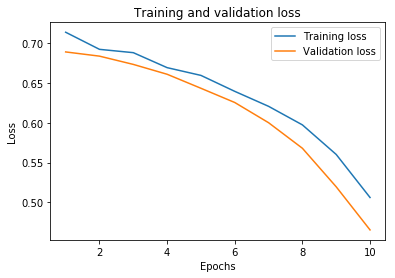

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

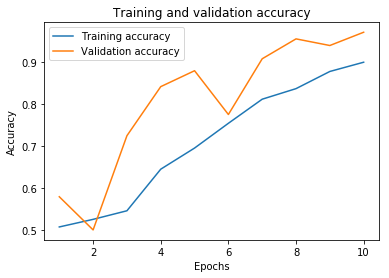

In [103]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [112]:
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [113]:
prediction = model.predict(test_data_padded)

In [114]:
test_label

array([0, 1], dtype=uint8)

In [115]:
prediction[random_num].argsort()[-len(prediction[random_num]):]

array([0, 1], dtype=int64)

In [116]:
test_data

'created_at: 2008-07-09 15:35:28+00:00 - text: Politico Mafioso: BARACK OBAMA\'S FISA FLIP FRONT AND CENTER http://tinyurl.com/56klth - created_at_user: Thu May 29 21:17:36 +0000 2008 - name_user: alaskaBNN - name_zero_user_mentions_entities: PolitiFact - location_user: Alaska - description_user:  - source: <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a> - display_url_zero_urls_entities: twitter.com/i/web/status/1… - contributors_enabled_user: False - default_profile_image_user: True - default_profile_user: False - display_url_zero_urls_url_entities_user: blognetnews.com/alaska - expanded_url_zero_urls_entities: http://aol.it/ZqFuvl - expanded_url_zero_urls_url_entities_user: http://www.blognetnews.com/alaska - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: False - has_extended_profile_user: False - id: 853806659.0 - id_str: 853806659.0 - id_str_user: 14948358 - id_str_zero_user_mentions_entities: 8953122 - id_user: 149

In [ ]:
input1 = Input(shape=(MAX_SEQ_LENGTH,), name='nlp_input') #TEXT
input2 = Input(shape=(10,), name='meta_input') #NON-TEXT ATTRS
emb = Embedding(output_dim=len(word_index) + 1, input_dim=EMBEDDING_DIM, weights = [embedding_matrix], 
                input_length=MAX_SEQ_LENGTH, 
                trainable=False, 
                name = ‘embeddings’)))(input1)
input1_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
merged = keras.layers.Concatenate(axis=1)([input1_out, input2])
maxpool = keras.layers.GlobalMaxPool1D()(merged)
dropout1 = keras.layers.Dropout(0.1)(maxpool)
dense1 = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dropout1)
dropout2 = keras.layers.Dropout(0.1)(dense1)
dense2 = keras.layers.Dense(2, input_dim=2, activation=keras.activations.sigmoid, use_bias=True)(dropout2)
model10 = keras.models.Model(inputs=[input1, input2], output=output)
model10.compile(optimizer=’adam’, loss=’binary_crossentropy’,
metrics = ['accuracy')
history = model0.fit([x_train, CAT_ATTRS],y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val))                                     
                
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history[‘loss’]
val_loss = history.history[‘val_loss’]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label=’Training loss’)
plt.plot(epochs, val_loss, label=’Validation loss’)
plt.title(‘Training and validation loss’)
plt.xlabel(‘Epochs’)
plt.ylabel(‘Loss’)
plt.legend()
plt.show();
                
accuracy = history.history[‘acc’]
val_accuracy = history.history[‘val_acc’]
plt.plot(epochs, accuracy, label=’Training accuracy’)
plt.plot(epochs, val_accuracy, label=’Validation accuracy’)
plt.title(‘Training and validation accuracy’)
plt.ylabel(‘Accuracy’)
plt.xlabel(‘Epochs’)
plt.legend()
plt.show();
                
random_num = np.random.randint(0, 100)
test_data = x[random_num]
test_label = y[random_num]
clean_test_data = clean_text(test_data)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(clean_test_data)
test_sequences = tokenizer.texts_to_sequences(clean_test_data)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = ‘post’, maxlen = MAX_SEQUENCE_LENGTH)
                
prediction = model.predict(test_data_padded)
                
prediction[random_num].argsort()[-len(prediction[random_num]):]